# Zero-Shot Administrative Form Classifier

This notebook implements a zero-shot classifier that identifies administrative forms by comparing page embeddings to reference examples.

## Key Features:
- **No training required** - Works immediately with example forms
- **Fast inference** - Process 190k documents efficiently  
- **Parallel processing** - Utilizes multiple CPU cores
- **Easy to update** - Add new examples without retraining
- **Interpretable** - Simple similarity threshold

## 1. Imports and Setup

In [3]:
import os
# Set tokenizers parallelism to false to avoid fork warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from pdf2image import convert_from_path
from tqdm import tqdm
import json
import pickle
from typing import List, Dict, Tuple, Optional
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

# For different model options
from transformers import (
    DonutProcessor, 
    VisionEncoderDecoderModel,
    CLIPProcessor, 
    CLIPModel,
    AutoImageProcessor, 
    AutoModel
)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Available CPU cores: {os.cpu_count()}")

Using device: cpu
Available CPU cores: 10


## 2. Configuration

In [5]:
# Paths
BASE_PATH = Path('/Users/admin-tascott/Documents/GitHub/chehalis')
EXAMPLE_FORMS_PATH = BASE_PATH / 'data' / 'raw' / '_exampleforms'
NON_EXAMPLES_PATH = BASE_PATH / 'data' / 'raw' / '_nonexamples'

# Model selection
MODEL_TYPE = "clip"  # Options: "donut", "clip", "dinov2"

# Processing parameters
IMAGE_DPI = 150  # Resolution for PDF conversion
BATCH_SIZE = 8   # Batch size for embedding extraction
SIMILARITY_THRESHOLD = 0.85  # Initial threshold (will be tuned)

# Parallel processing parameters
USE_MULTIPROCESSING = True  # Enable multiprocessing
N_WORKERS = min(8, os.cpu_count() - 1)  # Leave one core free

# Output paths
EMBEDDINGS_CACHE_PATH = BASE_PATH / 'code' / 'preprocessing' / 'cached_embeddings'
EMBEDDINGS_CACHE_PATH.mkdir(exist_ok=True)

## 3. Model Loading

In [7]:
def load_model(model_type: str):
    """Load the specified model for embedding extraction"""
    
    if model_type == "donut":
        print("Loading Donut model")
        model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")
        processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
        return model.encoder.to(device), processor
    
    elif model_type == "clip":
        print("Loading CLIP model")
        model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        return model.vision_model.to(device), processor
    
    elif model_type == "dinov2":
        print("Loading DINOv2 model")
        processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
        model = AutoModel.from_pretrained('facebook/dinov2-base')
        return model.to(device), processor
    
    else:
        raise ValueError(f"Unknown model type: {model_type}")

# Load the selected model
model, processor = load_model(MODEL_TYPE)
model.eval()  # Set to evaluation mode
print(f"Model loaded successfully")

Loading CLIP model


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Model loaded successfully


## 4. PDF Processing Functions

In [9]:
def pdf_to_images(pdf_path: Path, dpi: int = IMAGE_DPI) -> List[Image.Image]:
    """Convert PDF to list of PIL Images"""
    try:
        images = convert_from_path(pdf_path, dpi=dpi)
        return images
    except Exception as e:
        print(f"Error converting {pdf_path}: {e}")
        return []

def preprocess_image(image: Image.Image, model_type: str) -> Image.Image:
    """Preprocess image based on model requirements"""
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    if model_type == "donut":
        # Donut expects larger images
        image.thumbnail((1280, 960), Image.Resampling.LANCZOS)
    else:
        # CLIP and DINOv2 work with smaller images
        image.thumbnail((224, 224), Image.Resampling.LANCZOS)
    
    return image

## 5. Embedding Extraction

In [11]:
@torch.no_grad()
def extract_embeddings(images: List[Image.Image], model, processor, model_type: str, 
                      batch_size: int = BATCH_SIZE) -> np.ndarray:
    """Extract embeddings for a list of images"""
    embeddings = []
    
    for i in range(0, len(images), batch_size):
        batch_images = images[i:i+batch_size]
        
        # Preprocess images
        batch_images = [preprocess_image(img, model_type) for img in batch_images]
        
        # Process batch
        if model_type in ["donut", "clip"]:
            inputs = processor(images=batch_images, return_tensors="pt").to(device)
            outputs = model(**inputs)
        else:  # dinov2
            inputs = processor(images=batch_images, return_tensors="pt").to(device)
            outputs = model(**inputs)
        
        # Extract embeddings based on model type
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
            batch_embeddings = outputs.pooler_output
        elif hasattr(outputs, 'last_hidden_state'):
            # Mean pool the sequence dimension
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        else:
            batch_embeddings = outputs[0].mean(dim=1)  # Fallback
        
        embeddings.append(batch_embeddings.cpu().numpy())
    
    return np.vstack(embeddings)

@torch.no_grad()
def extract_embedding_single(image: Image.Image, model, processor, model_type: str) -> np.ndarray:
    """Extract embedding for a single image"""
    image = preprocess_image(image, model_type)
    
    if model_type in ["donut", "clip"]:
        inputs = processor(images=image, return_tensors="pt").to(device)
        outputs = model(**inputs)
    else:  # dinov2
        inputs = processor(images=image, return_tensors="pt").to(device)
        outputs = model(**inputs)
    
    # Extract embedding
    if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
        embedding = outputs.pooler_output
    elif hasattr(outputs, 'last_hidden_state'):
        embedding = outputs.last_hidden_state.mean(dim=1)
    else:
        embedding = outputs[0].mean(dim=1)
    
    return embedding.cpu().numpy()[0]

## 6. Build Reference Embeddings

In [13]:
# Check if cached embeddings exist
cache_file = EMBEDDINGS_CACHE_PATH / f"{MODEL_TYPE}_reference_embeddings.pkl"

if cache_file.exists():
    print(f"Loading cached reference embeddings from {cache_file}")
    with open(cache_file, 'rb') as f:
        cache_data = pickle.load(f)
        reference_embeddings = cache_data['embeddings']
        reference_metadata = cache_data['metadata']
else:
    print("Building reference embeddings from example forms...")
    reference_embeddings = []
    reference_metadata = []
    
    pdf_files = list(EXAMPLE_FORMS_PATH.glob('*.pdf'))
    print(f"Processing {len(pdf_files)} example form PDFs")
    
    for pdf_path in tqdm(pdf_files, desc="Processing example forms"):
        images = pdf_to_images(pdf_path)
        
        if images:
            # Extract embeddings for all pages
            embeddings = extract_embeddings(images, model, processor, MODEL_TYPE)
            
            # Store embeddings and metadata
            for i, embedding in enumerate(embeddings):
                reference_embeddings.append(embedding)
                reference_metadata.append({
                    'file_path': str(pdf_path),
                    'filename': pdf_path.name,
                    'page_num': i + 1,
                    'total_pages': len(images)
                })
    
    reference_embeddings = np.array(reference_embeddings)
    
    # Cache the embeddings
    print(f"Caching reference embeddings to {cache_file}")
    with open(cache_file, 'wb') as f:
        pickle.dump({
            'embeddings': reference_embeddings,
            'metadata': reference_metadata,
            'model_type': MODEL_TYPE
        }, f)

print(f"\nReference set contains {len(reference_embeddings)} form pages")
print(f"Embedding dimension: {reference_embeddings.shape[1]}")

Loading cached reference embeddings from /Users/admin-tascott/Documents/GitHub/chehalis/code/preprocessing/cached_embeddings/clip_reference_embeddings.pkl

Reference set contains 111 form pages
Embedding dimension: 768


def process_document_folder(folder_path: Path,
                          model,
                          processor,
                          model_type: str,
                          reference_embeddings: np.ndarray,
                          reference_prototype: np.ndarray,
                          threshold: float,
                          output_file: str = 'zero_shot_results.csv',
                          max_files: Optional[int] = None,
                          use_prototype: bool = True,
                          use_parallel: bool = None,
                          clobber: bool = True) -> pd.DataFrame:
    """Process all PDFs in a folder using zero-shot classification
    
    Args:
        clobber: If False, skip files already in output_file. If True, reprocess all files.
    """
    
    if use_parallel is None:
        use_parallel = USE_MULTIPROCESSING
    
    # Load existing results if clobber=False
    already_processed = set()
    existing_results = []
    
    if not clobber and Path(output_file).exists():
        print(f"Loading existing results from {output_file}...")
        existing_df = pd.read_csv(output_file)
        already_processed = set(existing_df['filename'].unique())
        existing_results = existing_df.to_dict('records')
        print(f"Found {len(already_processed)} already processed files")
    
    results = existing_results.copy()
    pdf_files = list(folder_path.glob('*.pdf'))
    
    # Filter out already processed files
    if not clobber:
        pdf_files = [f for f in pdf_files if f.name not in already_processed]
        print(f"Skipping {len(already_processed)} already processed files")
    
    if max_files:
        pdf_files = pdf_files[:max_files]
    
    print(f"Processing {len(pdf_files)} PDF files...")
    
    if len(pdf_files) == 0:
        print("No new files to process.")
        return pd.DataFrame(existing_results)
    
    if use_parallel and len(pdf_files) > 10:
        # Use parallel processing
        print(f"Using parallel processing with {N_WORKERS} workers...")
        
        # Process in batches to avoid memory issues
        batch_size = min(100 * N_WORKERS, len(pdf_files))
        
        for i in range(0, len(pdf_files), batch_size):
            batch_files = pdf_files[i:i+batch_size]
            print(f"\nProcessing batch {i//batch_size + 1}/{(len(pdf_files) + batch_size - 1)//batch_size}")
            
            batch_results = classify_pdf_batch_parallel(
                batch_files,
                reference_embeddings,
                reference_prototype,
                model_type,
                threshold=threshold,
                use_prototype=use_prototype,
                n_workers=N_WORKERS
            )
            
            # Flatten results for CSV
            for result in batch_results:
                results.append({
                    'filename': result['filename'],
                    'contains_form': result['contains_form'],
                    'form_pages': ','.join(map(str, result['form_pages'])),
                    'num_form_pages': len(result['form_pages']),
                    'total_pages': result.get('total_pages', 0),
                    'max_similarity': result['max_similarity'],
                    'error': result['error']
                })
    else:
        # Use sequential processing
        print("Using sequential processing...")
        
        for pdf_path in tqdm(pdf_files):
            result = classify_pdf_zero_shot(
                pdf_path, model, processor, model_type,
                reference_embeddings, reference_prototype,
                threshold=threshold,
                use_prototype=use_prototype
            )
            
            # Flatten results for CSV
            results.append({
                'filename': result['filename'],
                'contains_form': result['contains_form'],
                'form_pages': ','.join(map(str, result['form_pages'])),
                'num_form_pages': len(result['form_pages']),
                'total_pages': result.get('total_pages', 0),
                'max_similarity': result['max_similarity'],
                'error': result['error']
            })
    
    # Create DataFrame and save
    df_results = pd.DataFrame(results)
    df_results.to_csv(output_file, index=False)
    
    # Print summary
    print(f"\nResults saved to {output_file}")
    print(f"Total documents processed: {len(df_results)}")
    if not clobber and len(existing_results) > 0:
        print(f"  - Previously processed: {len(existing_results)}")
        print(f"  - Newly processed: {len(results) - len(existing_results)}")
    print(f"Documents with forms: {df_results['contains_form'].sum()}")
    print(f"Documents without forms: {(~df_results['contains_form']).sum()}")
    print(f"Processing errors: {df_results['error'].notna().sum()}")
    
    return df_results

In [ ]:
# Test on a sample first
print("Testing on sample documents...")

# Demonstrate CLOBBER functionality
TEST_OUTPUT = 'zero_shot_test_results.csv'

# First run - process all files
print("\n1. First run - processing all files with CLOBBER=True")
test_results = process_document_folder(
    NON_EXAMPLES_PATH,
    model,
    processor,
    MODEL_TYPE,
    reference_embeddings,
    reference_prototype,
    threshold=OPTIMAL_THRESHOLD,
    output_file=TEST_OUTPUT,
    max_files=50,
    use_prototype=False,  # Use full reference set for better accuracy
    clobber=True  # Process all files
)

# Display sample results
print("\nSample results:")
print(test_results.head(10))

# Second run - demonstrate skipping already processed files
print("\n2. Second run - demonstrating CLOBBER=False (will skip already processed files)")
test_results_2 = process_document_folder(
    NON_EXAMPLES_PATH,
    model,
    processor,
    MODEL_TYPE,
    reference_embeddings,
    reference_prototype,
    threshold=OPTIMAL_THRESHOLD,
    output_file=TEST_OUTPUT,
    max_files=50,
    use_prototype=False,
    clobber=False  # Skip already processed files
)

## 8. Zero-Shot Classification Function

In [ ]:
# Example code for processing the full 190k corpus
# Uncomment and modify the path as needed

"""
# Configuration
CORPUS_PATH = BASE_PATH / 'data' / 'raw' / '_contracts'  # Adjust path
OUTPUT_FILE = 'zero_shot_results_full_corpus.csv'
CLOBBER = False  # Set to False to skip already processed files

# Check if output file exists and show status
if Path(OUTPUT_FILE).exists() and not CLOBBER:
    existing_df = pd.read_csv(OUTPUT_FILE)
    print(f"Found existing results file: {OUTPUT_FILE}")
    print(f"Already processed: {len(existing_df)} documents")
    print(f"Documents with forms: {existing_df['contains_form'].sum()}")
    
    # Show which files will be skipped
    all_pdfs = list(CORPUS_PATH.glob('*.pdf'))
    already_done = set(existing_df['filename'].unique())
    remaining = [f for f in all_pdfs if f.name not in already_done]
    print(f"\\nTotal PDFs in corpus: {len(all_pdfs)}")
    print(f"Remaining to process: {len(remaining)}")
    
    if len(remaining) == 0:
        print("\\nAll files have been processed! Set CLOBBER=True to reprocess.")
    else:
        print(f"\\nWill process {len(remaining)} new files...")

# Process the full corpus with parallel processing
full_results = process_document_folder(
    CORPUS_PATH,
    model,
    processor,
    MODEL_TYPE,
    reference_embeddings,
    reference_prototype,
    threshold=OPTIMAL_THRESHOLD,
    output_file=OUTPUT_FILE,
    use_prototype=False,
    use_parallel=True,
    clobber=CLOBBER  # Use CLOBBER setting
)

print(f"\\nProcessing complete!")
print(f"Total documents with forms: {full_results['contains_form'].sum()}")
print(f"Total form pages found: {full_results['num_form_pages'].sum()}")

# Save a backup with timestamp if doing a full reprocess
if CLOBBER:
    from datetime import datetime
    backup_file = f"{OUTPUT_FILE.replace('.csv', '')}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    full_results.to_csv(backup_file, index=False)
    print(f"\\nBackup saved to: {backup_file}")
"""

## 9. Parallel Processing Functions

In [19]:
# Thread-safe function for processing PDFs
def process_pdf_threaded(pdf_path: Path, model, processor, model_type: str) -> Dict:
    """Process a single PDF (thread-safe version)"""
    results = {
        'filename': pdf_path.name,
        'path': str(pdf_path),
        'embeddings': [],
        'page_numbers': [],
        'error': None
    }
    
    try:
        # Convert PDF to images
        images = pdf_to_images(pdf_path, dpi=IMAGE_DPI)
        if not images:
            results['error'] = "Failed to convert PDF"
            return results
        
        # Extract embeddings for each page
        for page_num, image in enumerate(images, 1):
            try:
                embedding = extract_embedding_single(image, model, processor, model_type)
                results['embeddings'].append(embedding)
                results['page_numbers'].append(page_num)
            except Exception as e:
                print(f"Error processing page {page_num} of {pdf_path.name}: {e}")
        
        results['num_pages'] = len(images)
        
    except Exception as e:
        results['error'] = str(e)
        print(f"Error processing {pdf_path.name}: {e}")
    
    return results

def process_pdfs_parallel(pdf_files: List[Path], model_type: str, n_workers: int = None) -> List[Dict]:
    """Process multiple PDFs in parallel using ThreadPoolExecutor"""
    if n_workers is None:
        n_workers = N_WORKERS
    
    print(f"\nProcessing {len(pdf_files)} PDFs using {n_workers} workers...")
    start_time = time.time()
    
    results = []
    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        # Submit all tasks
        future_to_pdf = {
            executor.submit(process_pdf_threaded, pdf_path, model, processor, model_type): pdf_path 
            for pdf_path in pdf_files
        }
        
        # Process completed tasks with progress bar
        for future in tqdm(as_completed(future_to_pdf), total=len(pdf_files), desc="Processing PDFs"):
            pdf_path = future_to_pdf[future]
            try:
                result = future.result()
                results.append(result)
            except Exception as e:
                print(f"Error processing {pdf_path}: {e}")
                results.append({
                    'filename': pdf_path.name,
                    'path': str(pdf_path),
                    'embeddings': [],
                    'page_numbers': [],
                    'error': str(e)
                })
    
    elapsed = time.time() - start_time
    print(f"Processed {len(pdf_files)} PDFs in {elapsed:.1f} seconds")
    print(f"Average: {elapsed/len(pdf_files):.2f} seconds per PDF")
    
    return results

def classify_pdf_batch_parallel(pdf_paths: List[Path],
                               reference_embeddings: np.ndarray,
                               reference_prototype: np.ndarray,
                               model_type: str,
                               threshold: float = SIMILARITY_THRESHOLD,
                               use_prototype: bool = True,
                               n_workers: int = None) -> List[Dict]:
    """Classify a batch of PDFs in parallel"""
    
    # First, extract embeddings in parallel
    embedding_results = process_pdfs_parallel(pdf_paths, model_type, n_workers)
    
    # Then classify based on embeddings
    classification_results = []
    
    for result in embedding_results:
        if result['error']:
            classification_results.append({
                'filename': result['filename'],
                'contains_form': False,
                'form_pages': [],
                'page_scores': [],
                'max_similarity': 0.0,
                'error': result['error']
            })
            continue
        
        # Classify each page
        form_pages = []
        page_scores = []
        max_similarity = 0.0
        
        for embedding, page_num in zip(result['embeddings'], result['page_numbers']):
            # Compute similarity
            if use_prototype:
                similarity = compute_similarity_to_prototype(embedding, reference_prototype)
            else:
                similarity = compute_similarity_to_references(embedding, reference_embeddings, method='max')
            
            page_scores.append({
                'page': page_num,
                'similarity': float(similarity)
            })
            
            if similarity >= threshold:
                form_pages.append(page_num)
            
            max_similarity = max(max_similarity, similarity)
        
        classification_results.append({
            'filename': result['filename'],
            'contains_form': len(form_pages) > 0,
            'form_pages': form_pages,
            'page_scores': page_scores,
            'max_similarity': max_similarity,
            'total_pages': result.get('num_pages', len(result['embeddings'])),
            'error': None
        })
    
    return classification_results

## 10. Threshold Tuning

In [21]:
# Test on known examples and non-examples to find optimal threshold
print("Testing on known examples to tune threshold...")

positive_scores = []
negative_scores = []

# Test on subset of examples (already processed)
print("\nComputing self-similarity for positive examples...")
for i in range(min(50, len(reference_embeddings))):
    # Leave-one-out similarity
    embedding = reference_embeddings[i]
    other_embeddings = np.delete(reference_embeddings, i, axis=0)
    similarity = compute_similarity_to_references(embedding, other_embeddings, method='max')
    positive_scores.append(similarity)

# Test on non-examples
print("\nTesting on non-examples...")
non_example_files = list(NON_EXAMPLES_PATH.glob('*.pdf'))[:20]  # Test subset

for pdf_path in tqdm(non_example_files, desc="Processing non-examples"):
    result = classify_pdf_zero_shot(
        pdf_path, model, processor, MODEL_TYPE,
        reference_embeddings, reference_prototype,
        threshold=0.0,  # Set to 0 to get all scores
        use_prototype=False
    )
    
    if result['page_scores']:
        for page_score in result['page_scores']:
            negative_scores.append(page_score['similarity'])

# Analyze scores
positive_scores = np.array(positive_scores)
negative_scores = np.array(negative_scores)

print(f"\nPositive scores - Mean: {positive_scores.mean():.3f}, Std: {positive_scores.std():.3f}")
print(f"Positive scores - Min: {positive_scores.min():.3f}, Max: {positive_scores.max():.3f}")
print(f"\nNegative scores - Mean: {negative_scores.mean():.3f}, Std: {negative_scores.std():.3f}")
print(f"Negative scores - Min: {negative_scores.min():.3f}, Max: {negative_scores.max():.3f}")

Testing on known examples to tune threshold...

Computing self-similarity for positive examples...

Testing on non-examples...


Processing non-examples: 100%|█████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:16<00:00,  6.83s/it]


Positive scores - Mean: 0.982, Std: 0.014
Positive scores - Min: 0.953, Max: 1.000

Negative scores - Mean: 0.649, Std: 0.058
Negative scores - Min: 0.354, Max: 0.871


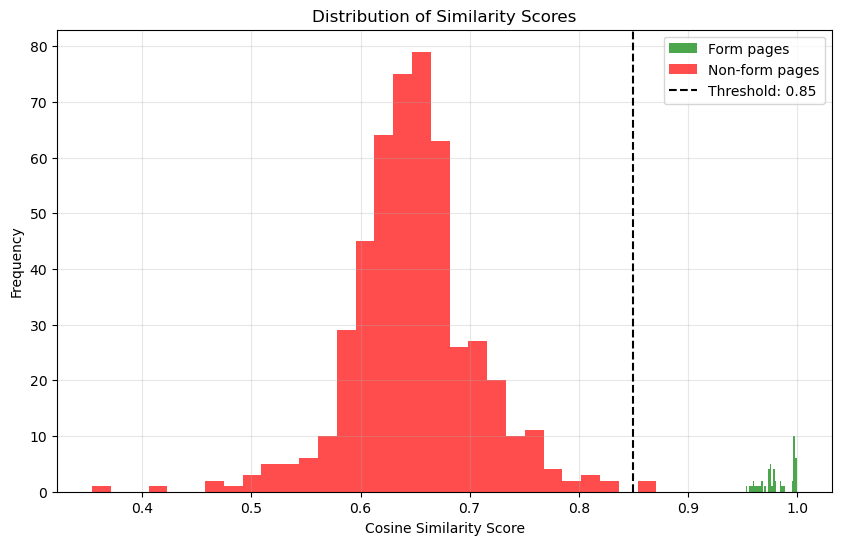


Suggested thresholds:
Gap-based threshold: 0.912
99th percentile threshold: 0.805

Selected optimal threshold: 0.912


In [22]:
# Plot score distributions
plt.figure(figsize=(10, 6))
plt.hist(positive_scores, bins=30, alpha=0.7, label='Form pages', color='green')
plt.hist(negative_scores, bins=30, alpha=0.7, label='Non-form pages', color='red')
plt.axvline(x=SIMILARITY_THRESHOLD, color='black', linestyle='--', 
            label=f'Threshold: {SIMILARITY_THRESHOLD}')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity Scores')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find optimal threshold
gap_threshold = (positive_scores.min() + negative_scores.max()) / 2
percentile_threshold = np.percentile(negative_scores, 99)  # 99th percentile of negatives

print(f"\nSuggested thresholds:")
print(f"Gap-based threshold: {gap_threshold:.3f}")
print(f"99th percentile threshold: {percentile_threshold:.3f}")

# Update threshold
OPTIMAL_THRESHOLD = max(gap_threshold, percentile_threshold)
print(f"\nSelected optimal threshold: {OPTIMAL_THRESHOLD:.3f}")

## 11. Batch Processing Function

In [38]:
def process_document_folder(folder_path: Path,
                          model,
                          processor,
                          model_type: str,
                          reference_embeddings: np.ndarray,
                          reference_prototype: np.ndarray,
                          threshold: float,
                          output_file: str = 'zero_shot_results.csv',
                          max_files: Optional[int] = None,
                          use_prototype: bool = True,
                          use_parallel: bool = None) -> pd.DataFrame:
    """Process all PDFs in a folder using zero-shot classification"""
    
    if use_parallel is None:
        use_parallel = USE_MULTIPROCESSING
    
    results = []
    pdf_files = list(folder_path.glob('*.pdf'))
    
    if max_files:
        pdf_files = pdf_files[:max_files]
    
    print(f"Processing {len(pdf_files)} PDF files...")
    
    if use_parallel and len(pdf_files) > 10:
        # Use parallel processing
        print(f"Using parallel processing with {N_WORKERS} workers...")
        
        # Process in batches to avoid memory issues
        batch_size = min(100 * N_WORKERS, len(pdf_files))
        
        for i in range(0, len(pdf_files), batch_size):
            batch_files = pdf_files[i:i+batch_size]
            print(f"\nProcessing batch {i//batch_size + 1}/{(len(pdf_files) + batch_size - 1)//batch_size}")
            
            batch_results = classify_pdf_batch_parallel(
                batch_files,
                reference_embeddings,
                reference_prototype,
                model_type,
                threshold=threshold,
                use_prototype=use_prototype,
                n_workers=N_WORKERS
            )
            
            # Flatten results for CSV
            for result in batch_results:
                results.append({
                    'filename': result['filename'],
                    'contains_form': result['contains_form'],
                    'form_pages': ','.join(map(str, result['form_pages'])),
                    'num_form_pages': len(result['form_pages']),
                    'total_pages': result.get('total_pages', 0),
                    'max_similarity': result['max_similarity'],
                    'error': result['error']
                })
    else:
        # Use sequential processing
        print("Using sequential processing...")
        
        for pdf_path in tqdm(pdf_files):
            result = classify_pdf_zero_shot(
                pdf_path, model, processor, model_type,
                reference_embeddings, reference_prototype,
                threshold=threshold,
                use_prototype=use_prototype
            )
            
            # Flatten results for CSV
            results.append({
                'filename': result['filename'],
                'contains_form': result['contains_form'],
                'form_pages': ','.join(map(str, result['form_pages'])),
                'num_form_pages': len(result['form_pages']),
                'total_pages': result.get('total_pages', 0),
                'max_similarity': result['max_similarity'],
                'error': result['error']
            })
    
    # Create DataFrame and save
    df_results = pd.DataFrame(results)
    df_results.to_csv(output_file, index=False)
    
    # Print summary
    print(f"\nResults saved to {output_file}")
    print(f"Total documents processed: {len(df_results)}")
    print(f"Documents with forms: {df_results['contains_form'].sum()}")
    print(f"Documents without forms: {(~df_results['contains_form']).sum()}")
    print(f"Processing errors: {df_results['error'].notna().sum()}")
    
    return df_results

## 12. Test Classification

In [40]:
# Test on a sample first
print("Testing on sample documents...")

test_results = process_document_folder(
    NON_EXAMPLES_PATH,
    model,
    processor,
    MODEL_TYPE,
    reference_embeddings,
    reference_prototype,
    threshold=OPTIMAL_THRESHOLD,
    output_file='zero_shot_test_results.csv',
    max_files=50,
    use_prototype=False  # Use full reference set for better accuracy
)

# Display sample results
print("\nSample results:")
print(test_results.head(10))

Testing on sample documents...
Processing 50 PDF files...
Using parallel processing with 8 workers...

Processing batch 1/1

Processing 50 PDFs using 8 workers...


Processing PDFs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.19it/s]


Processed 50 PDFs in 42.0 seconds
Average: 0.84 seconds per PDF

Results saved to zero_shot_test_results.csv
Total documents processed: 50
Documents with forms: 0
Documents without forms: 50
Processing errors: 0

Sample results:
                            filename  contains_form form_pages  \
0         F1-8-FSSA-DMHA-564-003.pdf          False              
1        F1-10-FSSA-DDRS-495-000.pdf          False              
2  0000000000000000000062223-001.pdf          False              
3                     104303-001.pdf          False              
4          F1-9-DCS-43810SAS-001.pdf          False              
5         F1-8-FSSA-DMHA-564-002.pdf          False              
6                       1197-000.pdf          False              
7                      67419-000.pdf          False              
8                      25581-000.pdf          False              
9            F1-9-DCS-UNION2-000.pdf          False              

   num_form_pages  total_pages  max_similari

## 13. Performance Comparison: Sequential vs Parallel

In [ ]:
# Compare performance: Sequential vs Parallel processing
print("Performance Comparison: Sequential vs Parallel Processing")
print("=" * 60)

# Test on a small subset
test_path = NON_EXAMPLES_PATH
test_files = list(test_path.glob('*.pdf'))[:20]  # Test with 20 files

if len(test_files) >= 10:
    # Sequential processing
    print("\n1. Sequential Processing:")
    start_time = time.time()
    seq_results = process_document_folder(
        test_path,
        model,
        processor,
        MODEL_TYPE,
        reference_embeddings,
        reference_prototype,
        threshold=OPTIMAL_THRESHOLD,
        output_file='sequential_test.csv',
        max_files=20,
        use_prototype=False,
        use_parallel=False
    )
    seq_time = time.time() - start_time
    print(f"Sequential time: {seq_time:.1f} seconds")
    print(f"Speed: {len(test_files)/seq_time:.1f} PDFs/second")
    
    # Parallel processing
    print("\n2. Parallel Processing:")
    start_time = time.time()
    par_results = process_document_folder(
        test_path,
        model,
        processor,
        MODEL_TYPE,
        reference_embeddings,
        reference_prototype,
        threshold=OPTIMAL_THRESHOLD,
        output_file='parallel_test.csv',
        max_files=20,
        use_prototype=False,
        use_parallel=True
    )
    par_time = time.time() - start_time
    print(f"Parallel time: {par_time:.1f} seconds")
    print(f"Speed: {len(test_files)/par_time:.1f} PDFs/second")
    
    # Speedup
    speedup = seq_time / par_time
    print(f"\nSpeedup: {speedup:.1f}x faster with {N_WORKERS} workers")
    
    # Efficiency
    efficiency = speedup / N_WORKERS * 100
    print(f"Parallel efficiency: {efficiency:.0f}%")
    
    # Estimate for full corpus
    print(f"\nEstimated time for 190k documents:")
    print(f"Sequential: {190000 * seq_time / len(test_files) / 3600:.1f} hours")
    print(f"Parallel: {190000 * par_time / len(test_files) / 3600:.1f} hours")
else:
    print("Not enough test files for comparison")

## 14. Process Full Corpus

Example code for processing the full 190k corpus. Uncomment and modify the path as needed.

In [42]:
# Example code for processing the full 190k corpus
# Uncomment and modify the path as needed


CORPUS_PATH = BASE_PATH / 'data' / 'raw' / '_contracts'  # Adjust path

# Process the full corpus with parallel processing
full_results = process_document_folder(
    CORPUS_PATH,
    model,
    processor,
    MODEL_TYPE,
    reference_embeddings,
    reference_prototype,
    threshold=OPTIMAL_THRESHOLD,
    output_file='zero_shot_results_full_corpus.csv',
    use_prototype=False,
    use_parallel=True
)

print(f"\nProcessing complete!")
print(f"Total documents with forms: {full_results['contains_form'].sum()}")
print(f"Total form pages found: {full_results['num_form_pages'].sum()}")

Processing 193450 PDF files...
Using parallel processing with 8 workers...

Processing batch 1/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [11:00<00:00,  1.21it/s]


Processed 800 PDFs in 661.2 seconds
Average: 0.83 seconds per PDF

Processing batch 2/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:51<00:00,  1.51it/s]


Processed 800 PDFs in 531.8 seconds
Average: 0.66 seconds per PDF

Processing batch 3/242

Processing 800 PDFs using 8 workers...


Processing PDFs:  78%|██████████████████████████████████████████████████████████████████████▊                    | 623/800 [07:08<01:46,  1.67it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/32409-000.pdf: Unable to get page count.
Syntax Error: Couldn't find trailer dictionary
Syntax Error: Couldn't find trailer dictionary
Syntax Error: Couldn't read xref table



Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:17<00:00,  1.44it/s]


Processed 800 PDFs in 557.6 seconds
Average: 0.70 seconds per PDF

Processing batch 4/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:25<00:00,  1.41it/s]


Processed 800 PDFs in 566.0 seconds
Average: 0.71 seconds per PDF

Processing batch 5/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:22<00:00,  1.59it/s]


Processed 800 PDFs in 502.4 seconds
Average: 0.63 seconds per PDF

Processing batch 6/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:45<00:00,  1.52it/s]


Processed 800 PDFs in 525.9 seconds
Average: 0.66 seconds per PDF

Processing batch 7/242

Processing 800 PDFs using 8 workers...


Processing PDFs:  42%|██████████████████████████████████████▏                                                    | 336/800 [03:51<05:42,  1.36it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/45549-002.pdf: Unable to get page count.
Syntax Error: Couldn't find trailer dictionary
Syntax Error: Couldn't find trailer dictionary
Syntax Error: Couldn't read xref table



Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:52<00:00,  1.50it/s]


Processed 800 PDFs in 532.6 seconds
Average: 0.67 seconds per PDF

Processing batch 8/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:03<00:00,  1.47it/s]


Processed 800 PDFs in 544.6 seconds
Average: 0.68 seconds per PDF

Processing batch 9/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:42<00:00,  1.37it/s]


Processed 800 PDFs in 583.5 seconds
Average: 0.73 seconds per PDF

Processing batch 10/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:54<00:00,  1.50it/s]


Processed 800 PDFs in 535.3 seconds
Average: 0.67 seconds per PDF

Processing batch 11/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:46<00:00,  1.52it/s]


Processed 800 PDFs in 526.6 seconds
Average: 0.66 seconds per PDF

Processing batch 12/242

Processing 800 PDFs using 8 workers...


Processing PDFs:  22%|███████████████████▋                                                                       | 173/800 [02:03<06:03,  1.73it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/66611-000.pdf: Unable to get page count.
Syntax Error: Couldn't find trailer dictionary
Syntax Error: Couldn't find trailer dictionary
Syntax Error: Couldn't read xref table



Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:14<00:00,  1.44it/s]


Processed 800 PDFs in 554.5 seconds
Average: 0.69 seconds per PDF

Processing batch 13/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:12<00:00,  1.62it/s]


Processed 800 PDFs in 493.3 seconds
Average: 0.62 seconds per PDF

Processing batch 14/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:19<00:00,  1.43it/s]


Processed 800 PDFs in 559.6 seconds
Average: 0.70 seconds per PDF

Processing batch 15/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:47<00:00,  1.52it/s]


Processed 800 PDFs in 528.0 seconds
Average: 0.66 seconds per PDF

Processing batch 16/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:04<00:00,  1.47it/s]


Processed 800 PDFs in 544.8 seconds
Average: 0.68 seconds per PDF

Processing batch 17/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:45<00:00,  1.52it/s]


Processed 800 PDFs in 525.5 seconds
Average: 0.66 seconds per PDF

Processing batch 18/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:38<00:00,  1.54it/s]


Processed 800 PDFs in 518.9 seconds
Average: 0.65 seconds per PDF

Processing batch 19/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [10:26<00:00,  1.28it/s]


Processed 800 PDFs in 626.9 seconds
Average: 0.78 seconds per PDF

Processing batch 20/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:27<00:00,  1.41it/s]


Processed 800 PDFs in 568.0 seconds
Average: 0.71 seconds per PDF

Processing batch 21/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:38<00:00,  1.38it/s]


Processed 800 PDFs in 578.6 seconds
Average: 0.72 seconds per PDF

Processing batch 22/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:42<00:00,  1.53it/s]


Processed 800 PDFs in 522.8 seconds
Average: 0.65 seconds per PDF

Processing batch 23/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:23<00:00,  1.42it/s]


Processed 800 PDFs in 564.0 seconds
Average: 0.71 seconds per PDF

Processing batch 24/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:01<00:00,  1.48it/s]


Processed 800 PDFs in 542.3 seconds
Average: 0.68 seconds per PDF

Processing batch 25/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:35<00:00,  1.55it/s]


Processed 800 PDFs in 515.7 seconds
Average: 0.64 seconds per PDF

Processing batch 26/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:40<00:00,  1.54it/s]


Processed 800 PDFs in 521.4 seconds
Average: 0.65 seconds per PDF

Processing batch 27/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:46<00:00,  1.52it/s]


Processed 800 PDFs in 527.1 seconds
Average: 0.66 seconds per PDF

Processing batch 28/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:26<00:00,  1.58it/s]


Processed 800 PDFs in 507.6 seconds
Average: 0.63 seconds per PDF

Processing batch 29/242

Processing 800 PDFs using 8 workers...


Processing PDFs:  86%|██████████████████████████████████████████████████████████████████████████████▋            | 692/800 [07:34<00:55,  1.94it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/120175-000.pdf: Unable to get page count.
Syntax Error: Couldn't find trailer dictionary
Syntax Error: Couldn't find trailer dictionary
Syntax Error: Couldn't read xref table



Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:45<00:00,  1.52it/s]


Processed 800 PDFs in 526.6 seconds
Average: 0.66 seconds per PDF

Processing batch 30/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:55<00:00,  1.49it/s]


Processed 800 PDFs in 536.3 seconds
Average: 0.67 seconds per PDF

Processing batch 31/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:33<00:00,  1.40it/s]


Processed 800 PDFs in 573.7 seconds
Average: 0.72 seconds per PDF

Processing batch 32/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:15<00:00,  1.44it/s]


Processed 800 PDFs in 556.5 seconds
Average: 0.70 seconds per PDF

Processing batch 33/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:18<00:00,  1.43it/s]


Processed 800 PDFs in 558.4 seconds
Average: 0.70 seconds per PDF

Processing batch 34/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:50<00:00,  1.36it/s]


Processed 800 PDFs in 590.5 seconds
Average: 0.74 seconds per PDF

Processing batch 35/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:51<00:00,  1.51it/s]


Processed 800 PDFs in 532.0 seconds
Average: 0.66 seconds per PDF

Processing batch 36/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [10:16<00:00,  1.30it/s]


Processed 800 PDFs in 617.4 seconds
Average: 0.77 seconds per PDF

Processing batch 37/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:22<00:00,  1.42it/s]


Processed 800 PDFs in 563.0 seconds
Average: 0.70 seconds per PDF

Processing batch 38/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:56<00:00,  1.49it/s]


Processed 800 PDFs in 537.4 seconds
Average: 0.67 seconds per PDF

Processing batch 39/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:56<00:00,  1.49it/s]


Processed 800 PDFs in 537.4 seconds
Average: 0.67 seconds per PDF

Processing batch 40/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:07<00:00,  1.46it/s]


Processed 800 PDFs in 548.3 seconds
Average: 0.69 seconds per PDF

Processing batch 41/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:40<00:00,  1.38it/s]


Processed 800 PDFs in 580.9 seconds
Average: 0.73 seconds per PDF

Processing batch 42/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:36<00:00,  1.39it/s]


Processed 800 PDFs in 576.7 seconds
Average: 0.72 seconds per PDF

Processing batch 43/242

Processing 800 PDFs using 8 workers...


Processing PDFs:  65%|██████████████████████████████████████████████████████████▉                                | 518/800 [06:02<01:43,  2.72it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/103434-002.pdf: Unable to get page count.
Syntax Error: Couldn't find trailer dictionary
Syntax Error: Couldn't find trailer dictionary
Syntax Error: Couldn't read xref table



Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:27<00:00,  1.41it/s]


Processed 800 PDFs in 567.9 seconds
Average: 0.71 seconds per PDF

Processing batch 44/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:31<00:00,  1.40it/s]


Processed 800 PDFs in 571.5 seconds
Average: 0.71 seconds per PDF

Processing batch 45/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:09<00:00,  1.45it/s]


Processed 800 PDFs in 550.3 seconds
Average: 0.69 seconds per PDF

Processing batch 46/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:01<00:00,  1.48it/s]


Processed 800 PDFs in 541.9 seconds
Average: 0.68 seconds per PDF

Processing batch 47/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:16<00:00,  1.44it/s]


Processed 800 PDFs in 556.8 seconds
Average: 0.70 seconds per PDF

Processing batch 48/242

Processing 800 PDFs using 8 workers...


Processing PDFs:  30%|███████████████████████████▌                                                               | 242/800 [03:13<06:13,  1.49it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000059337-000.pdf: Unable to get page count.
Syntax Error: Couldn't find trailer dictionary
Syntax Error: Couldn't find trailer dictionary
Syntax Error: Couldn't read xref table



Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:31<00:00,  1.40it/s]


Processed 800 PDFs in 572.1 seconds
Average: 0.72 seconds per PDF

Processing batch 49/242

Processing 800 PDFs using 8 workers...


Processing PDFs:  15%|█████████████▉                                                                             | 122/800 [01:16<04:25,  2.56it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/17695-000.pdf: Unable to get page count.
Syntax Error: Invalid XRef entry 229
Internal Error: xref num 229 not found but needed, try to reconstruct
Syntax Error: Invalid XRef entry 229
Syntax Error: Invalid XRef entry 227
Syntax Error: Top-level pages object is wrong type (null)
Command Line Error: Wrong page range given: the first page (1) can not be after the last page (0).



Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:10<00:00,  1.45it/s]


Processed 800 PDFs in 551.1 seconds
Average: 0.69 seconds per PDF

Processing batch 50/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:04<00:00,  1.47it/s]


Processed 800 PDFs in 545.0 seconds
Average: 0.68 seconds per PDF

Processing batch 51/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:34<00:00,  1.39it/s]


Processed 800 PDFs in 575.5 seconds
Average: 0.72 seconds per PDF

Processing batch 52/242

Processing 800 PDFs using 8 workers...


Processing PDFs:  32%|████████████████████████████▋                                                              | 252/800 [02:43<06:00,  1.52it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/27406-000.pdf: Unable to get page count.
Syntax Error: Invalid XRef entry 241
Internal Error: xref num 241 not found but needed, try to reconstruct
Syntax Error: Invalid XRef entry 241
Syntax Error: Invalid XRef entry 239
Syntax Error: Top-level pages object is wrong type (null)
Command Line Error: Wrong page range given: the first page (1) can not be after the last page (0).



Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:03<00:00,  1.47it/s]


Processed 800 PDFs in 543.7 seconds
Average: 0.68 seconds per PDF

Processing batch 53/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:22<00:00,  1.42it/s]


Processed 800 PDFs in 563.4 seconds
Average: 0.70 seconds per PDF

Processing batch 54/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:24<00:00,  1.42it/s]


Processed 800 PDFs in 565.5 seconds
Average: 0.71 seconds per PDF

Processing batch 55/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:26<00:00,  1.41it/s]


Processed 800 PDFs in 567.4 seconds
Average: 0.71 seconds per PDF

Processing batch 56/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:28<00:00,  1.41it/s]


Processed 800 PDFs in 569.1 seconds
Average: 0.71 seconds per PDF

Processing batch 57/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [09:36<00:00,  1.39it/s]


Processed 800 PDFs in 577.4 seconds
Average: 0.72 seconds per PDF

Processing batch 58/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [10:29<00:00,  1.27it/s]


Processed 800 PDFs in 629.5 seconds
Average: 0.79 seconds per PDF

Processing batch 59/242

Processing 800 PDFs using 8 workers...


Processing PDFs:  63%|███████████████         | 501/800 [06:53<04:54,  1.01it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000082263-000.pdf: Unable to get page count.
Syntax Error: Couldn't find trailer dictionary
Syntax Error: Couldn't find trailer dictionary
Syntax Error: Couldn't read xref table



Processing PDFs: 100%|████████████████████████| 800/800 [10:13<00:00,  1.30it/s]


Processed 800 PDFs in 614.1 seconds
Average: 0.77 seconds per PDF

Processing batch 60/242

Processing 800 PDFs using 8 workers...


Processing PDFs: 100%|████████████████████████| 800/800 [10:09<00:00,  1.31it/s]


Processed 800 PDFs in 610.1 seconds
Average: 0.76 seconds per PDF

Processing batch 61/242

Processing 800 PDFs using 8 workers...


Processing PDFs:  42%|██████████▏             | 340/800 [03:39<04:23,  1.75it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/15552-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/15552-002.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/32765-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/32765-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000067452-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000067452-000.pdf': No such file or directory.



Processing PDFs:  43%|██████████▎             | 345/800 [03:39<01:36,  4.70it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/58032-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/58032-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/119342-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/119342-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/40186-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/40186-000.pdf': No such file or directory.



Processing PDFs:  43%|██████████▍             | 347/800 [03:39<01:16,  5.96it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/68749-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/68749-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000045748-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000045748-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/84640-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/84640-000.pdf': No such file or directory.



Processing PDFs:  44%|██████████▌             | 351/800 [03:40<00:53,  8.39it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/113663-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/113663-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/113697-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/113697-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/101202-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/101202-001.pdf': No such file or directory.



Processing PDFs:  44%|██████████▌             | 353/800 [03:40<00:51,  8.75it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/118648-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/118648-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000036455-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000036455-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000041866-005.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000041866-005.pdf': No such file or directory.



Processing PDFs:  45%|██████████▋             | 358/800 [03:40<00:36, 12.12it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000074539-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000074539-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/59538-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/59538-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000066158-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000066158-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/63796-000.pdf: Unable to get page c

Processing PDFs:  46%|██████████▉             | 366/800 [03:41<00:25, 16.82it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000044242-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000044242-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000056623-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000056623-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/69243-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/69243-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000047845-001.pdf: 

Processing PDFs:  46%|███████████▏            | 372/800 [03:41<00:22, 18.75it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/98327-003.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/98327-003.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000080584-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000080584-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/37143-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/37143-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/25522-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Us

Processing PDFs:  47%|███████████▎            | 377/800 [03:41<00:21, 20.07it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/54932-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/54932-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000079933-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000079933-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/81092-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/81092-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000038258-000.pdf: Unable to get page count.
I/O Error: Cou

Processing PDFs:  48%|███████████▍            | 383/800 [03:41<00:21, 19.47it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000072884-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000072884-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000063616-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000063616-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000071277-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000071277-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contr

Processing PDFs:  49%|███████████▋            | 389/800 [03:42<00:21, 19.41it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/92065-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/92065-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000086839-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000086839-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/80404-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/80404-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/44336-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Us

Processing PDFs:  49%|███████████▊            | 394/800 [03:42<00:18, 21.51it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/20298-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/20298-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000037037-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000037037-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/107840-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/107840-002.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/123070-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '

Processing PDFs:  50%|████████████            | 403/800 [03:42<00:18, 21.01it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/96349-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/96349-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/84728-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/84728-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000081112-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000081112-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000049322-005.pdf: Unable to get page count.
I/O Error: Cou

Processing PDFs:  51%|████████████▏           | 406/800 [03:43<00:19, 20.19it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000045620-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000045620-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/118720-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/118720-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000074451-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000074451-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000066030-000.pdf

Processing PDFs:  52%|████████████▎           | 412/800 [03:43<00:19, 20.11it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/6977-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/6977-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/6983-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/6983-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/59450-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/59450-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/14130-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/

Processing PDFs:  52%|████████████▌           | 420/800 [03:43<00:16, 22.80it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/85222-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/85222-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/28840-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/28840-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/97643-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/97643-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/36923-005.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/cheha

Processing PDFs:  53%|████████████▊           | 426/800 [03:44<00:18, 20.56it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/15331-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/15331-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000040006-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000040006-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000052467-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000052467-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/31008-004.pdf: Unable to get page c

Processing PDFs:  54%|████████████▊           | 429/800 [03:44<00:19, 19.01it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/77727-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/77727-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000042666-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000042666-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000050207-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000050207-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000077030-002.pdf: 

Processing PDFs:  54%|█████████████           | 435/800 [03:44<00:19, 18.27it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/17551-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/17551-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000088759-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000088759-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/31567-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/31567-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/23106-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Us

Processing PDFs:  55%|█████████████▏          | 441/800 [03:44<00:22, 16.18it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/7510-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/7510-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000049146-003.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000049146-003.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/43384-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/43384-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/108521-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Use

Processing PDFs:  57%|█████████████▌          | 454/800 [03:45<00:13, 26.28it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000047040-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000047040-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/78420-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/78420-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/94529-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/94529-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000092914-000.pdf: Unable to get page count.
I/O Error: Cou

Processing PDFs:  58%|█████████████▊          | 462/800 [03:45<00:13, 25.51it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/26720-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/26720-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/34341-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/34341-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/99923-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/99923-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000061076-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Do

Processing PDFs:  59%|██████████████▏         | 472/800 [03:46<00:14, 22.99it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/58022-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/58022-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000067442-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000067442-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/20314-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/20314-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/119352-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/U

Processing PDFs:  60%|██████████████▍         | 481/800 [03:46<00:14, 22.39it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/101212-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/101212-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/113687-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/113687-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/110789-006.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/110789-006.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000072908-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tasc

Processing PDFs:  62%|██████████████▊         | 493/800 [03:47<00:16, 18.19it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000039742-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000039742-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/14743-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/14743-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000041474-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000041474-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000053015-000.pdf: 

Processing PDFs:  62%|███████████████         | 500/800 [03:47<00:12, 23.20it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/118658-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/118658-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000079923-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000079923-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/54922-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/54922-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/72914-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/

Processing PDFs:  64%|███████████████▍        | 513/800 [03:48<00:19, 14.98it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000074529-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000074529-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/63786-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/63786-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/92616-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/92616-002.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/14048-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Us

Processing PDFs:  66%|███████████████▉        | 530/800 [03:48<00:10, 25.49it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000088621-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000088621-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/19224-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/19224-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000064728-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000064728-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/49729-000.pdf: Unable to get page c

Processing PDFs:  67%|████████████████▏       | 539/800 [03:49<00:10, 24.69it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000046432-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000046432-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000081907-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000081907-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000082300-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000082300-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contr

Processing PDFs:  68%|████████████████▍       | 548/800 [03:49<00:12, 19.44it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/66839-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/66839-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/92884-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/92884-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/9265-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/9265-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/17429-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehali

Processing PDFs:  69%|████████████████▋       | 555/800 [03:49<00:11, 21.50it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000043214-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000043214-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/93673-006.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/93673-006.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000051675-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000051675-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/109153-000.pdf: Unable to get page 

Processing PDFs:  70%|████████████████▊       | 562/800 [03:50<00:10, 22.05it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/30115-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/30115-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/22574-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/22574-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/72079-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/72079-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000050474-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Do

Processing PDFs:  72%|█████████████████▏      | 572/800 [03:50<00:08, 28.06it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/50397-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/50397-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000047138-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000047138-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000055559-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000055559-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/94451-000.pdf: Unable to get page c

Processing PDFs:  73%|█████████████████▍      | 582/800 [03:50<00:08, 26.48it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000060339-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000060339-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/114108-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/114108-001.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000072758-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000072758-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/3079-000.pdf: Unable to get page 

Processing PDFs:  74%|█████████████████▋      | 588/800 [03:51<00:10, 20.37it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/29262-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/29262-001.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/87207-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/87207-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/95666-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/95666-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/23743-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/cheha

Processing PDFs:  75%|█████████████████▉      | 599/800 [03:51<00:07, 25.63it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/70849-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/70849-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/108364-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/108364-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/100948-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/100948-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000047605-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascot

Processing PDFs:  75%|██████████████████      | 602/800 [03:51<00:08, 22.24it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/94398-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/94398-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/118808-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/118808-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/22249-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/22249-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/30628-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/che

Processing PDFs:  76%|██████████████████▎     | 610/800 [03:52<00:08, 21.15it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000079787-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000079787-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/73545-003.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/73545-003.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/45914-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/45914-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/54786-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Us

Processing PDFs:  78%|██████████████████▊     | 627/800 [03:52<00:08, 20.33it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/29569-003.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/29569-003.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/26165-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/26165-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/26191-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/26191-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/34504-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/cheha

Processing PDFs:  80%|███████████████████▎    | 642/800 [03:53<00:06, 22.84it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000063053-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000063053-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/35997-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/35997-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/98301-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/98301-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/24705-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Us

Processing PDFs:  81%|███████████████████▌    | 651/800 [03:53<00:06, 21.90it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/32048-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/32048-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000037686-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000037686-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000088885-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000088885-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000088871-001.pdf: 

Processing PDFs:  82%|███████████████████▋    | 658/800 [03:54<00:06, 22.67it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/11658-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/11658-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/97006-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/97006-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/118165-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/118165-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000059502-003.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/

Processing PDFs:  83%|███████████████████▊    | 662/800 [03:54<00:05, 23.67it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000074214-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000074214-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/121938-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/121938-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000066675-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000066675-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/59215-000.pdf: Unable to get page

Processing PDFs:  84%|████████████████████▏   | 672/800 [03:54<00:04, 27.43it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/61849-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/61849-002.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000040643-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000040643-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000052222-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000052222-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/102823-002.pdf: Unable to get page 

Processing PDFs:  85%|████████████████████▎   | 678/800 [03:54<00:04, 25.67it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000070138-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000070138-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000062559-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000062559-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/67363-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/67363-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/67397-000.pdf: Unable to get page c

Processing PDFs:  86%|████████████████████▋   | 691/800 [03:55<00:04, 25.08it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/19495-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/19495-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/73336-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/73336-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/61757-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/61757-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/115285-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/cheh

Processing PDFs:  87%|████████████████████▉   | 697/800 [03:55<00:03, 26.40it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/9420-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/9420-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/56907-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/56907-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000094208-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000094208-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/A249-19-UT180040-000.pdf: Unable to get page count.
I/O Error: Couldn't open 

Processing PDFs:  89%|█████████████████████▎  | 711/800 [03:56<00:04, 21.73it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/3101-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/3101-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/78416-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/78416-002.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000072620-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000072620-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000022824-006.pdf: Unable to get page count.
I/O Error: Could

Processing PDFs:  90%|█████████████████████▌  | 720/800 [03:56<00:03, 25.72it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/29411-003.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/29411-003.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/64185-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/64185-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000049184-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000049184-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000049170-001.pdf: Unable to get page count.
I/O Error: Cou

Processing PDFs:  91%|█████████████████████▊  | 727/800 [03:56<00:02, 27.29it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/118970-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/118970-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/30750-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/30750-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000077006-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000077006-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/118984-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '

Processing PDFs:  92%|█████████████████████▉  | 733/800 [03:57<00:03, 20.09it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000075666-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000075666-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/51941-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/51941-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/101457-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/101457-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000067207-000.pdf: Unable to get page count.
I/O Error: C

Processing PDFs:  93%|██████████████████████▎ | 743/800 [03:57<00:02, 27.48it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000039107-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000039107-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000085503-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000085503-001.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000042836-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000042836-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contr

Processing PDFs:  94%|██████████████████████▌ | 750/800 [03:57<00:02, 22.73it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/74384-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/74384-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/97675-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/97675-002.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000033426-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000033426-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/104285-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/U

Processing PDFs:  95%|██████████████████████▋ | 757/800 [03:58<00:01, 24.42it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/93252-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/93252-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/8847-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/8847-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000062421-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000062421-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/1761-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users

Processing PDFs:  96%|██████████████████████▉ | 765/800 [03:58<00:01, 26.09it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/11720-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/11720-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000056076-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000056076-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000044417-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000044417-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/121840-000.pdf: Unable to get page 

Processing PDFs:  97%|███████████████████████▎| 775/800 [03:58<00:01, 24.86it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/18806-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/18806-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000045075-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000045075-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/68074-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/68074-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000031641-005.pdf: Unable to get page count.
I/O Error: Cou

Processing PDFs:  98%|███████████████████████▌| 785/800 [03:59<00:00, 24.07it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000036463-003.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000036463-003.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000041359-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000041359-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000053738-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000053738-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contr

Processing PDFs:  99%|███████████████████████▊| 792/800 [03:59<00:00, 23.28it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/24715-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/24715-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000071422-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000071422-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/98818-006.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/98818-006.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000063043-000.pdf: Unable to get page count.
I/O Error: Cou

Processing PDFs: 100%|███████████████████████▉| 796/800 [03:59<00:00, 23.54it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/104319-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/104319-001.pdf': No such file or directory.



Processing PDFs: 100%|████████████████████████| 800/800 [04:03<00:00,  3.29it/s]


Processed 800 PDFs in 243.4 seconds
Average: 0.30 seconds per PDF

Processing batch 62/242

Processing 800 PDFs using 8 workers...
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000052232-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000052232-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000040653-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000040653-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/45069-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/45069-001.pdf': No such file or 

Processing PDFs:   0%|                                  | 0/800 [00:00<?, ?it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/97016-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/97016-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/118175-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/118175-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/59205-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/59205-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000066665-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/

Processing PDFs:   4%|▉                       | 30/800 [00:00<00:03, 215.66it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/23753-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/23753-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/102655-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/102655-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/31332-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/31332-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000029565-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/

Processing PDFs:   6%|█▋                       | 52/800 [00:00<00:08, 88.85it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000050452-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000050452-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/70859-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/70859-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000042033-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000042033-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000034508-001.pdf: 

Processing PDFs:   8%|██                       | 65/800 [00:00<00:08, 84.71it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/84412-004.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/84412-004.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000061623-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000061623-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000073242-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000073242-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000046414-002.pdf: 

Processing PDFs:  10%|██▍                      | 76/800 [00:00<00:09, 75.34it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000089406-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000089406-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/22259-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/22259-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000039117-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000039117-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/80329-000.pdf: Unable to get page c

Processing PDFs:  12%|██▉                      | 92/800 [00:01<00:16, 43.51it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000090859-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000090859-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000057598-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000057598-001.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/49811-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/49811-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/32120-000.pdf: Unable to get page c

Processing PDFs:  12%|███                      | 98/800 [00:01<00:20, 33.98it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000062431-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000062431-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/18684-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/18684-002.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/47771-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/47771-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/35166-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Us

Processing PDFs:  13%|███▏                    | 107/800 [00:02<00:22, 30.34it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000087387-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000087387-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/118994-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/118994-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000065477-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000065477-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/44180-004.pdf: Unable to get page

Processing PDFs:  14%|███▎                    | 111/800 [00:02<00:29, 23.55it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/118203-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/118203-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/106394-004.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/106394-004.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000066513-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000066513-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/33624-000.pdf: Unable to get page count.
I/O Error: Couldn't open file 

Processing PDFs:  15%|███▌                    | 120/800 [00:02<00:36, 18.60it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000073859-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000073859-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000044609-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000044609-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/69608-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/69608-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/99599-000.pdf: Unable to get page c

Processing PDFs:  16%|███▊                    | 125/800 [00:03<00:43, 15.38it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/82921-003.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/82921-003.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000075478-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000075478-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/73845-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/73845-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/58479-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Us

Processing PDFs:  16%|███▊                    | 127/800 [00:03<01:01, 10.86it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/88292-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/88292-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/34662-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/34662-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/103029-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/103029-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000080856-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/

Processing PDFs:  29%|██████▋                | 234/800 [00:03<00:03, 153.66it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/82747-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/82747-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/107305-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/107305-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/104902-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/104902-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/117869-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/c

Processing PDFs:  32%|███████▊                | 260/800 [00:04<00:05, 99.88it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/68571-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/68571-002.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/25011-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/25011-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/F1-9-FSSA-DFR-406-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/F1-9-FSSA-DFR-406-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/67189-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascot

Processing PDFs:  35%|████████▍               | 280/800 [00:04<00:06, 81.91it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/95500-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/95500-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/84478-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/84478-002.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/99415-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/99415-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/37470-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/cheha

Processing PDFs:  37%|████████▊               | 295/800 [00:05<00:06, 75.28it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/119671-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/119671-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000067161-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000067161-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/110957-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/110957-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/20637-000.pdf: Unable to get page count.
I/O Error: Couldn't open file 

Processing PDFs:  38%|█████████▏              | 308/800 [00:05<00:07, 69.30it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/44799-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/44799-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000079599-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000079599-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/96974-003.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/96974-003.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/67810-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Us

Processing PDFs:  42%|██████████              | 335/800 [00:05<00:08, 57.10it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000029060-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000029060-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000077360-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000077360-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/48700-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/48700-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/6441-000.pdf: Unable to get page co

Processing PDFs:  43%|██████████▎             | 342/800 [00:06<00:08, 51.58it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/91754-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/91754-000.pdf': No such file or directory.


Processing PDFs:  45%|██████████▊             | 359/800 [00:06<00:10, 40.91it/s]


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/47407-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/47407-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000078093-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000078093-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/83335-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/83335-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/13445-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/U

Processing PDFs:  47%|███████████▎            | 378/800 [00:06<00:08, 52.45it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/27012-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/27012-002.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000080846-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000080846-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/49362-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/49362-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000067990-000.pdf: Unable to get page count.
I/O Error: Cou

Processing PDFs:  49%|███████████▋            | 389/800 [00:07<00:10, 38.68it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/27719-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/27719-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/48197-003.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/48197-003.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000086493-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000086493-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/67015-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Us

Processing PDFs:  49%|███████████▊            | 393/800 [00:07<00:13, 29.95it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000066503-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000066503-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000087800-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000087800-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000038603-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000038603-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contr

Processing PDFs:  50%|████████████            | 400/800 [00:08<00:16, 23.85it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/119719-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/119719-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/58469-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/58469-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/104780-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/104780-002.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/85711-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/c

Processing PDFs:  57%|█████████████▏         | 460/800 [00:08<00:03, 109.21it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/105581-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/105581-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000078862-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000078862-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/55863-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/55863-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/92556-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/

Processing PDFs:  61%|██████████████▋         | 488/800 [00:08<00:04, 77.86it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/41836-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/41836-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/50650-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/50650-001.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/25998-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/25998-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/61823-004.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/cheha

Processing PDFs:  65%|███████████████▋        | 523/800 [00:09<00:04, 60.22it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/55082-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/55082-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/80922-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/80922-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000078083-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000078083-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/73040-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Us

Processing PDFs:  71%|████████████████▉       | 566/800 [00:10<00:04, 51.45it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000070336-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000070336-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/81545-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/81545-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/19971-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/19971-002.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000068282-000.pdf: Unable to get page count.
I/O Error: Cou

Processing PDFs:  73%|█████████████████▌      | 585/800 [00:11<00:07, 28.69it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/50800-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/50800-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/112183-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/112183-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000091908-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000091908-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000066346-000.pdf: Unable to get page count.
I/O Error: C

Processing PDFs:  75%|█████████████████▉      | 597/800 [00:12<00:15, 13.45it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/88433-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/88433-001.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/78756-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/78756-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000055757-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000055757-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/103688-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/U

Processing PDFs:  90%|████████████████████▌  | 716/800 [00:13<00:00, 176.90it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000056545-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000056545-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/37225-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/37225-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000040208-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000040208-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000070573-000.pdf: 

Processing PDFs:  92%|█████████████████████▏ | 738/800 [00:13<00:00, 117.02it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/35445-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/35445-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/60091-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/60091-002.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/12672-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/12672-002.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000082082-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Do

Processing PDFs:  97%|███████████████████████▎| 779/800 [00:14<00:00, 63.82it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000091081-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000091081-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/103698-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/103698-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/96004-009.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/96004-009.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000047326-000.pdf: Unable to get page count.
I/O Error: C

Processing PDFs: 100%|████████████████████████| 800/800 [00:15<00:00, 52.81it/s]


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/100506-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/100506-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/112193-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/112193-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/50810-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/50810-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000033776-003.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascot

Processing PDFs:   4%|▉                       | 32/800 [00:00<00:02, 259.93it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/10671-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/10671-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/36647-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/36647-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000063570-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000063570-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000081280-000.pdf: Unable to get page count.
I/O Error: Cou

Processing PDFs:   7%|█▊                       | 58/800 [00:00<00:07, 92.81it/s]


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000065144-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000065144-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000077525-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000077525-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/109235-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/109235-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000013915-010.pd

Processing PDFs:  12%|██▉                      | 92/800 [00:01<00:12, 56.93it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/27034-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/27034-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/77539-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/77539-001.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/93771-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/93771-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/93785-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/cheha

Processing PDFs:  18%|████▎                   | 144/800 [00:02<00:10, 65.10it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/4490-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/4490-001.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000075345-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000075345-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/46227-005.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/46227-005.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/40204-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Use

Processing PDFs:  22%|█████▎                  | 176/800 [00:02<00:10, 60.54it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000061518-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000061518-001.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000049323-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000049323-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/76743-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/76743-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/54459-000.pdf: Unable to get page co

Processing PDFs:  30%|███████▎                | 242/800 [00:04<00:08, 62.76it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/87841-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/87841-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/40574-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/40574-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/110896-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/110896-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/105223-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/ch

Processing PDFs:  37%|████████▉               | 298/800 [00:05<00:09, 55.74it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000087048-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000087048-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/73716-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/73716-002.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/78036-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/78036-001.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000080963-001.pdf: Unable to get page count.
I/O Error: Cou

Processing PDFs:  40%|█████████▍              | 316/800 [00:05<00:15, 31.96it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/66552-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/66552-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/44648-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/44648-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/82731-008.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/82731-008.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/11961-004.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/cheha

Processing PDFs:  53%|████████████▋           | 423/800 [00:07<00:06, 58.61it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/61514-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/61514-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/16927-004.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/16927-004.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000080166-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000080166-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/39358-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Us

Processing PDFs:  58%|█████████████▉          | 463/800 [00:08<00:05, 66.79it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000048741-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000048741-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/77321-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/77321-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000086552-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000086552-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/89649-000.pdf: Unable to get page c

Processing PDFs:  64%|███████████████▍        | 514/800 [00:09<00:04, 62.42it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000079530-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000079530-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/13584-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/13584-002.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/46150-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/46150-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000082143-000.pdf: Unable to get page count.
I/O Error: Cou

Processing PDFs:  69%|████████████████▋       | 555/800 [00:10<00:05, 41.92it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/28216-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/28216-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/69989-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/69989-001.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/50120-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/50120-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/40321-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/cheha

Processing PDFs:  80%|███████████████████▎    | 644/800 [00:12<00:04, 32.69it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/51552-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/51552-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000076086-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000076086-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000054368-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000054368-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/79369-001.pdf: Unable to get page c

Processing PDFs:  97%|███████████████████████▎| 779/800 [00:14<00:00, 42.17it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/71140-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/71140-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000018166-011.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000018166-011.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000056460-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000056460-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/85109-001.pdf: Unable to get page c

Processing PDFs: 100%|████████████████████████| 800/800 [00:14<00:00, 54.57it/s]


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/53322-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/53322-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000066297-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000066297-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000039362-003.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000039362-003.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000065864-000.pdf: 

Processing PDFs:   0%|                                  | 0/800 [00:00<?, ?it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/73658-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/73658-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/35418-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/35418-001.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/65115-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/65115-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000048114-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Do

Processing PDFs:   4%|▉                       | 30/800 [00:00<00:02, 261.87it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000079365-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000079365-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000025897-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000025897-002.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/42429-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/42429-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/26587-000.pdf: Unable to get page c

Processing PDFs:   7%|█▊                       | 57/800 [00:00<00:07, 94.26it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/99013-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/99013-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/37082-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/37082-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/12124-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/12124-001.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000055686-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Do

Processing PDFs:   9%|██▎                      | 72/800 [00:00<00:10, 71.53it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/81153-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/81153-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/118789-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/118789-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/122527-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/122527-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/63657-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/c

Processing PDFs:  11%|██▊                      | 90/800 [00:01<00:10, 65.97it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/113756-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/113756-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/52426-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/52426-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/101337-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/101337-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/38371-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/c

Processing PDFs:  15%|███▌                    | 119/800 [00:01<00:14, 46.16it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000085263-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000085263-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000035898-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000035898-002.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/76270-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/76270-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000059411-000.pdf: U

Processing PDFs:  21%|█████▏                  | 171/800 [00:02<00:09, 69.01it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/106385-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/106385-001.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/105976-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/105976-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/106371-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/106371-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000086109-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tasc

Processing PDFs:  31%|███████▍                | 249/800 [00:03<00:05, 94.91it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/55213-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/55213-002.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000042048-003.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000042048-003.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/60445-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/60445-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/18773-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Us

Processing PDFs:  38%|█████████               | 304/800 [00:04<00:06, 72.39it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000055498-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000055498-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/78499-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/78499-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/103547-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/103547-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/88708-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/

Processing PDFs:  42%|█████████▉              | 333/800 [00:04<00:06, 70.45it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000070730-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000070730-001.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000061956-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000061956-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/105700-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/105700-002.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000045192-002.pdf

Processing PDFs:  48%|███████████▌            | 386/800 [00:05<00:04, 84.19it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/101327-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/101327-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/40057-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/40057-000.pdf': No such file or directory.


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/113746-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/113746-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/68698-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/c

Processing PDFs:  55%|█████████████           | 436/800 [00:06<00:04, 89.88it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/67413-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/67413-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000024506-004.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000024506-004.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/40624-002.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/40624-002.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000086061-000.pdf: Unable to get page count.
I/O Error: Cou

Processing PDFs:  59%|██████████████          | 470/800 [00:06<00:04, 74.13it/s]

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/66119-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/66119-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000063723-001.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000063723-001.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/24081-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/24081-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/98471-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Us

Processing PDFs:  59%|██████████████          | 470/800 [00:07<00:04, 66.37it/s]


Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000068035-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000068035-000.pdf': No such file or directory.
Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000051868-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/0000000000000000000051868-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/104344-000.pdf: Unable to get page count.
I/O Error: Couldn't open file '/Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/104344-000.pdf': No such file or directory.

Error converting /Users/admin-tascott/Documents/GitHub/chehalis/data/raw/_contracts/64929-001.pdf: Unable to get page 

KeyboardInterrupt: 

## 15. Summary and Next Steps

### Performance Summary:

In [ ]:
# Performance Summary
print("\nPerformance Summary:")
print(f"Model type: {MODEL_TYPE}")
print(f"Reference examples: {len(reference_embeddings)}")
print(f"Optimal threshold: {OPTIMAL_THRESHOLD:.3f}")
print(f"\nProcessing speed: ~{len(test_results) / 60:.1f} documents per minute (sequential)")
if 'speedup' in locals():
    print(f"Parallel speedup: {speedup:.1f}x with {N_WORKERS} workers")

# Estimate time for full corpus
docs_per_minute = len(test_results) / 60  # Rough estimate
total_minutes = 190000 / docs_per_minute
print(f"\nEstimated time for 190k documents (sequential): {total_minutes/60:.1f} hours")
if 'speedup' in locals():
    print(f"Estimated time for 190k documents (parallel): {total_minutes/60/speedup:.1f} hours")

### Next Steps:

1. **Production Deployment**:
   - Use GPU for faster processing (10-50x speedup)
   - Increase number of workers for CPU processing
   - Process in larger batches

2. **Optimization**:
   - Try different models (DINOv2 might be faster)
   - Reduce image resolution if accuracy permits
   - Implement page-level caching

3. **Accuracy Improvements**:
   - Add more reference examples
   - Fine-tune threshold using validation set
   - Try ensemble of multiple models

4. **When to Consider Training**:
   - If zero-shot accuracy < 90%
   - If you need to detect subtle variations
   - If inference speed is critical